fetching mushroom dataset


C:\Users\ACER\AppData\Local\Temp\ipykernel_11564\3947576928.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, col] = le.fit_transform(X[col])
C:\Users\ACER\AppData\Local\Temp\ipykernel_11564\3947576928.py:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, col] = le.fit_transform(X[col])
C:\Users\ACER\AppData\Local\Temp\ipykernel_11564\3947576928.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

iter 0, loss: 0.6937575570678354
iter 1000, loss: 0.14523917529765173
iter 2000, loss: 0.13672313375820602
iter 3000, loss: 0.13427161614529484
iter 4000, loss: 0.1328345690049478
iter 5000, loss: 0.13194550773916594
iter 6000, loss: 0.13149146491200817
iter 7000, loss: 0.13112966157033282
iter 8000, loss: 0.1307460272639961
iter 9000, loss: 0.13092663707465674
training accuracy: 95.77 %


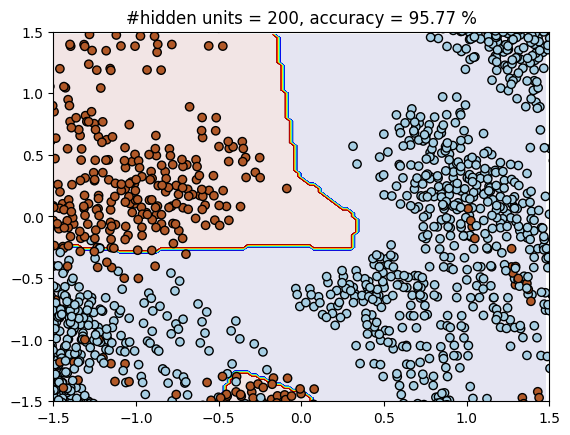

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo  

# Tải và xử lý dữ liệu nấm
print("fetching mushroom dataset")
iris = fetch_ucirepo(id=73)  # Tải dữ liệu nấm từ UCI Repository

# Chuyển dữ liệu sang dạng DataFrame
X = iris.data.features
y = iris.data.targets

# Mã hóa các biến phân loại
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == "object":
        X.loc[:, col] = le.fit_transform(X[col])

X = np.asarray(X)
y = np.asarray(y).flatten()

# Chuẩn hóa các đặc trưng
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mã hóa one-hot cho các nhãn
onehot_encoder = OneHotEncoder()
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = onehot_encoder.transform(y_test.reshape(-1, 1)).toarray()

# Giảm chiều dữ liệu xuống còn 2 bằng PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Chuyển đổi nhãn thành dạng one-hot encoding
def convert_labels(y, C):
    Y = np.eye(C)[y]
    return Y.T

# Đặt các tham số cho MLP
d0 = 2  # số chiều đầu vào sau PCA
d1 = 200  # kích thước của lớp ẩn
d2 = 2  # số lượng lớp đầu ra (độc hại, ăn được)
W1 = 0.01 * np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))
W2 = 0.01 * np.random.randn(d1, d2)
b2 = np.zeros((d2, 1))

# Chuẩn bị dữ liệu
X = X_pca.T
Y = convert_labels(np.argmax(y_train, axis=1), d2)  # y_train đã được mã hóa one-hot, cần chuyển đổi ngược lại
N = X.shape[1]
eta = 1  # tốc độ học

# Huấn luyện MLP
for i in range(10000):
    # Truyền tín hiệu xuôi
    Z1 = np.dot(W1.T, X) + b1
    A1 = np.maximum(Z1, 0)  # kích hoạt ReLU
    Z2 = np.dot(W2.T, A1) + b2
    Yhat = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)  # softmax

    # Tính toán mất mát: mất mát trung bình entropy chéo
    loss = -np.sum(Y * np.log(Yhat)) / N
    
    # In ra mất mát sau mỗi 1000 lần lặp
    if i % 1000 == 0:
        print(f"iter {i}, loss: {loss}")

    # Lan truyền ngược
    E2 = (Yhat - Y) / N
    dW2 = np.dot(A1, E2.T)
    db2 = np.sum(E2, axis=1, keepdims=True)
    E1 = np.dot(W2, E2)
    E1[Z1 <= 0] = 0  # gradient của ReLU
    dW1 = np.dot(X, E1.T)
    db1 = np.sum(E1, axis=1, keepdims=True)

    # Cập nhật bằng Gradient descent
    W1 -= eta * dW1
    b1 -= eta * db1
    W2 -= eta * dW2
    b2 -= eta * db2

# Đánh giá mô hình
Z1 = np.dot(W1.T, X) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = (100 * np.mean(predicted_class == np.argmax(y_train, axis=1)))
print(f'training accuracy: {acc:.2f} %')

# Hiển thị kết quả
xm = np.arange(-1.5, 1.5, 0.025)
ym = np.arange(-1.5, 1.5, 0.025)
xx, yy = np.meshgrid(xm, ym)
xx1 = xx.ravel().reshape(1, xx.size)
yy1 = yy.ravel().reshape(1, yy.size)
X0 = np.vstack((xx1, yy1))

Z1 = np.dot(W1.T, X0) + b1
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
Z = np.argmax(Z2, axis=0)
Z = Z.reshape(xx.shape)
CS = plt.contourf(xx, yy, Z, 200, cmap='jet', alpha=.1)

# Vẽ các điểm dữ liệu huấn luyện
plt.scatter(X[0, :N], X[1, :N], c=np.argmax(Y, axis=0), edgecolors='k', cmap=plt.cm.Paired)
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title(f'#hidden units = {d1}, accuracy = {acc:.2f} %')
plt.show()
